In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shape
from scipy import stats 
import seaborn as sns
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(10, 10)})

In [2]:
# Step 1. Choose about 3-6 variables from your dataset (2-3 – target variables, the rest -
# predictors).

In [3]:
df = pd.read_csv('data/FW_Veg_Rem_Combined.csv')
df = df.iloc[:, 2:]

df = df[df['disc_pre_year'] > 1991]

In [4]:
cont_columns_prefix = ['Prec_pre_', "Temp_pre_", "Wind_pre_", "Hum_pre_"]
columns_suffix = [7, 15, 30]

weather_columns = [ x + str(y) for x in cont_columns_prefix for y in columns_suffix]
# not realistic values, probably just a stub on values (all equal -1 or all equal 0)
#df = df[(df.loc[:, weather_columns] != -1).all(axis=1) & (df.loc[:, weather_columns] != 0).all(axis=1)]



In [57]:
#columns we are going to take in analysis 
weather_columns = ['Prec_pre_30', 'Temp_pre_30', 'Wind_pre_30', 'Hum_pre_30']

In [6]:
month_map = {x: y for x, y in  list(zip(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], range(1, 13)))}
reverse_month_map = {y: x for x, y in month_map.items()}

In [10]:
target_columns = ['fire_count', 'fire_size']

df['day'] = pd.to_datetime(df['disc_clean_date']).map(lambda x: x.day)
df['month'] = pd.to_datetime(df['disc_clean_date']).map(lambda x: x.month)
cont_columns_prefix = ['Prec_pre_', "Temp_pre_", "Wind_pre_", "Hum_pre_"]
fire_count_columns =["disc_pre_year", "discovery_month", 'month'] + [ x + '30' for x in cont_columns_prefix]

df_fires_count = df.groupby(['disc_pre_year', 'discovery_month', 'month']).size().reset_index().rename({0: 'fire_count'}, axis=1)
df_fires_size = df.groupby(['disc_pre_year', 'discovery_month', 'month'])['fire_size'].sum().reset_index()

data_fire_count = df.sort_values(['disc_pre_year', 'month', 'day'],
    ascending=False).drop_duplicates(['disc_pre_year', 'discovery_month'], keep='first')[fire_count_columns]

data = df_fires_count.merge(df_fires_size).merge(data_fire_count)

In [ ]:
data.reset_index('')

In [16]:
data.head()

,disc_pre_year,discovery_month,month,fire_count,fire_size,Prec_pre_30,Temp_pre_30,Wind_pre_30,Hum_pre_30
4,1992,Jan,1,38,226.54,0.0,3.711273,3.049818,80.741818
3,1992,Feb,2,268,13296.84,23.5,9.856860,3.556436,63.038348
7,1992,Mar,3,306,22166.51,-1.0,-1.000000,-1.000000,-1.000000
0,1992,Apr,4,268,12093.30,0.0,12.304323,4.519913,67.806886
8,1992,May,5,220,26981.76,-1.0,-1.000000,-1.000000,-1.000000


In [45]:
data['disc_year_month'] = data['disc_pre_year'].astype(str) + data['month'].map(lambda x: '-' + str(x) if len(str(x)) == 2 else '-0' + str(x))

data['disc_year_month']  = pd.to_datetime(data['disc_year_month'])
data.sort_values('disc_year_month', ascending=True, inplace=True)
data = data.set_index('disc_year_month')

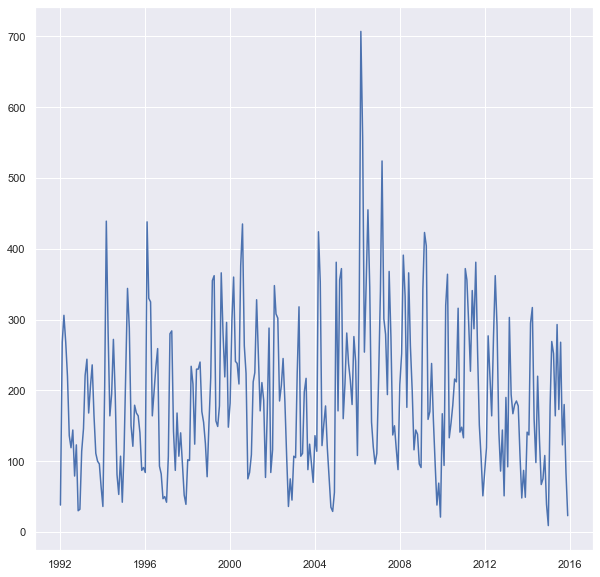

In [47]:
plt.plot(data['fire_count'])

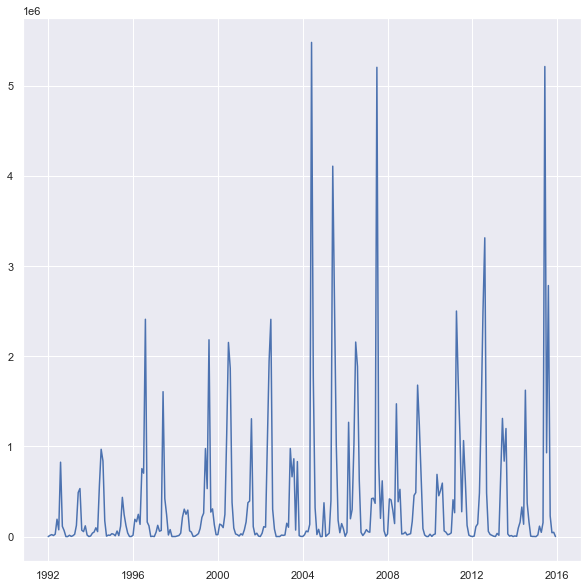

In [48]:
plt.plot(data['fire_size'])

In [29]:
#Analyze stationarity of a process (for mathematical expectation and variance) for all
#chosen variables. Make them more stationary if needed.
#

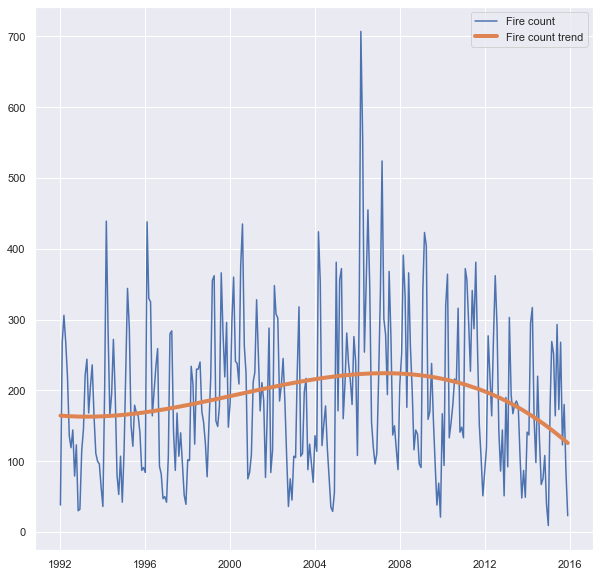

In [54]:
def trendline(data, order=9):
    #polynomial trend
    df = data.reset_index()
    trend = np.polyfit(data.index.values, list(data), order)
    return np.poly1d(trend)(data.index.values)

trend = trendline(data.reset_index()['fire_count'], 3)
plt.plot(data.index, data['fire_count'], label='Fire count')
plt.plot(data.index, trend, linewidth=4, label='Fire count trend')

plt.legend()
plt.show()

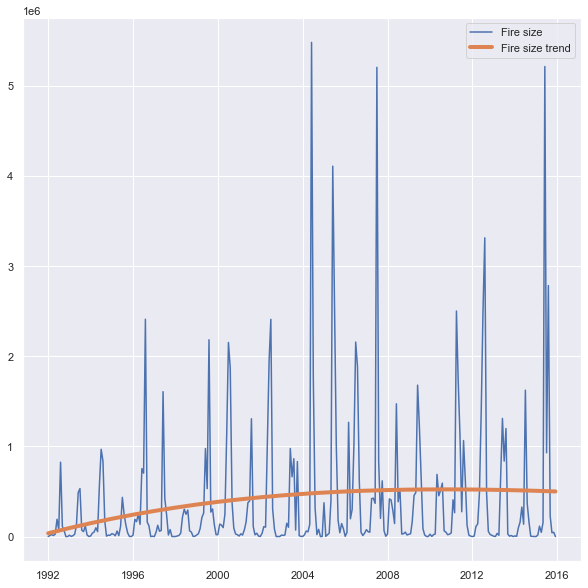

In [55]:
trend = trendline(data.reset_index()['fire_size'], 3)
plt.plot(data.index, data['fire_size'], label='Fire size')
plt.plot(data.index, trend, linewidth=4, label='Fire size trend')

plt.legend()
plt.show()

In [ ]:
# Analyze covariance or correlation function for chosen target variables and mutual
# correlation functions among predictors and targets.

In [ ]:
# You need to make an estimation of pair correlation coefficients, confidence intervals
# for them and significance levels.

In [85]:
data.head()

,disc_pre_year,discovery_month,month,count,Prec_pre_30,Temp_pre_30,Wind_pre_30,Hum_pre_30,disc_year_month
5,1992,Jan,1,38,0.0,3.711273,3.049818,80.741818,1992-01
4,1992,Feb,2,268,23.5,9.856860,3.556436,63.038348,1992-02
8,1992,Mar,3,306,-1.0,-1.000000,-1.000000,-1.000000,1992-03
1,1992,Apr,4,268,0.0,12.304323,4.519913,67.806886,1992-04
9,1992,May,5,220,-1.0,-1.000000,-1.000000,-1.000000,1992-05


In [87]:
for column in weather_columns + ['disc_pre_year', 'month']:
    # Confidence interval for the correlation coefficient
    x = data[column].apply(lambda x: float(x))
    y = data['fire_count'].apply(lambda x: float(x))
    r, p = stats.pearsonr(x, y)
    r_z = np.arctanh(r) # matches Fisher transform
    # Corresponding standard deviation
    se = 1/np.sqrt(x.size-3)
    alpha = 0.05
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    print('fire_count and', column)
    print('Correlation coefficient = ', r)
    print("p-value:\t", p)
    print(f'Confidence interval for the correlation coefficient low: {lo_z}, high: {hi_z}')
    print('')

fire_size and Prec_pre_30
Correlation coefficient =  0.0662232706625702
p-value:	 0.2626333675212673
Confidence interval for the correlation coefficient low: -0.049777912613221356, high: 0.18241858072488665

fire_size and Temp_pre_30
Correlation coefficient =  0.06892789707953566
p-value:	 0.24359612024629665
Confidence interval for the correlation coefficient low: -0.0470608772776866, high: 0.1851356160604214

fire_size and Wind_pre_30
Correlation coefficient =  0.0820822247453998
p-value:	 0.1647510122202086
Confidence interval for the correlation coefficient low: -0.03383093034665338, high: 0.1983655629914546

fire_size and Hum_pre_30
Correlation coefficient =  -0.057014821704941765
p-value:	 0.33497064383146424
Confidence interval for the correlation coefficient low: -0.1731749683176779, high: 0.059021525020430086

fire_size and disc_pre_year
Correlation coefficient =  0.0740226531725443
p-value:	 0.2104016416855494
Confidence interval for the correlation coefficient low: -0.041939

In [58]:
for column in weather_columns + ['disc_pre_year', 'month']:
    # Confidence interval for the correlation coefficient
    x = data[column].apply(lambda x: float(x))
    y = data['fire_size'].apply(lambda x: float(x))
    r, p = stats.pearsonr(x, y)
    r_z = np.arctanh(r) # matches Fisher transform
    # Corresponding standard deviation
    se = 1/np.sqrt(x.size-3)
    alpha = 0.05
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    print('fire_size and', column)
    print('Correlation coefficient = ', r)
    print("p-value:\t", p)
    print(f'Confidence interval for the correlation coefficient low: {lo_z}, high: {hi_z}')
    print('')

fire_size and Prec_pre_30
Correlation coefficient =  -0.06482801770530283
p-value:	 0.2728437580369339
Confidence interval for the correlation coefficient low: -0.1810173110307381, high: 0.05117918230736988

fire_size and Temp_pre_30
Correlation coefficient =  0.31345011719165405
p-value:	 5.5153753089397865e-08
Confidence interval for the correlation coefficient low: 0.20826862649035327, high: 0.44046511982846126

fire_size and Wind_pre_30
Correlation coefficient =  0.07178268556315229
p-value:	 0.2245713704994656
Confidence interval for the correlation coefficient low: -0.04419188567993676, high: 0.18800460765817123

fire_size and Hum_pre_30
Correlation coefficient =  0.026555150801393354
p-value:	 0.6535938898425552
Confidence interval for the correlation coefficient low: -0.08953685120665425, high: 0.14265964213145374

fire_size and disc_pre_year
Correlation coefficient =  0.15726966400202488
p-value:	 0.00749507111004773
Confidence interval for the correlation coefficient low: 0.0

In [59]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

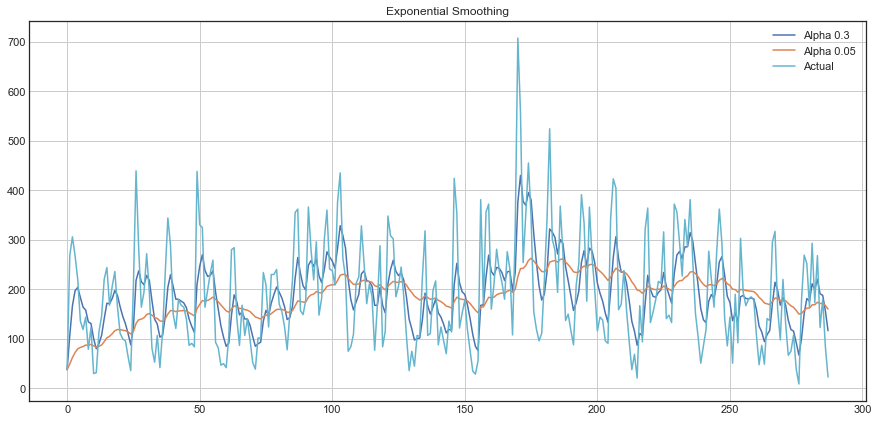

In [60]:
plotExponentialSmoothing(data['fire_count'], [0.3, 0.05])

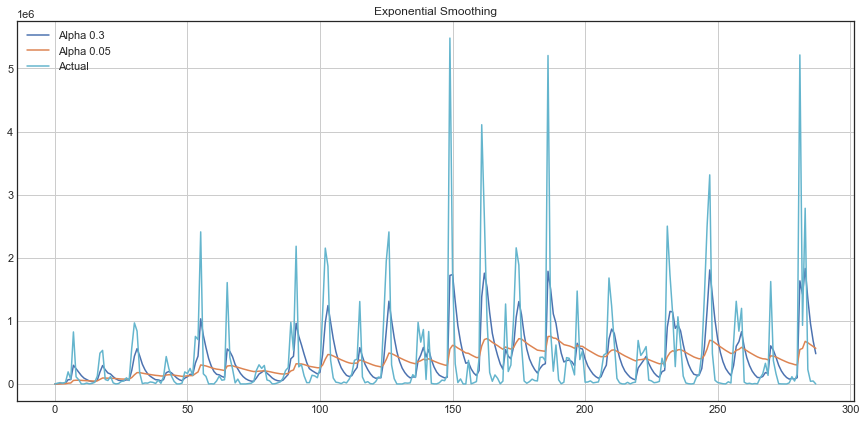

In [61]:
plotExponentialSmoothing(data['fire_size'], [0.3, 0.05])

In [62]:
data['exp_fire_count'] = exponential_smoothing(data['fire_count'], 0.3)
data['exp_fire_size'] = exponential_smoothing(data['fire_size'], 0.3)

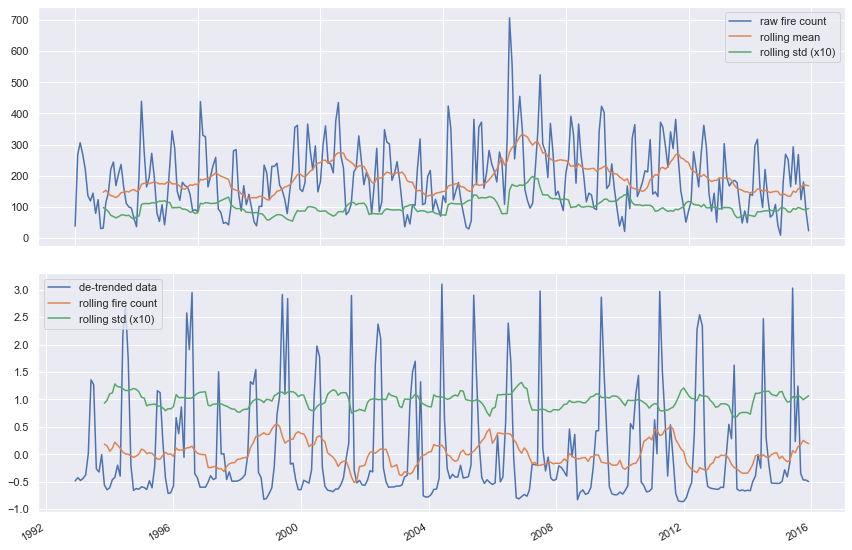

In [65]:
# data['z_data'] = (data['fire_count'] - data['fire_count'].rolling(window=12).mean()) / data['fire_count'].rolling(window=12).std()
# data['zp_data'] = data['z_data'] - data['z_data'].shift(12)

def plot_rolling(df, column):
    fig, ax = plt.subplots(2,figsize=(12, 9))
    ax[0].plot(df.index, df[column], label='raw fire count')
    ax[0].plot(df[column].rolling(window=12).mean(), label="rolling mean");
    ax[0].plot(df[column].rolling(window=12).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df.index, df.z_data, label="de-trended data")
    ax[1].plot(df[f'{column}_z_data'].rolling(window=12).mean(), label="rolling fire count");
    ax[1].plot(df[f'{column}_z_data'].rolling(window=12).std(), label="rolling std (x10)");
    ax[1].legend()


    plt.tight_layout()
    fig.autofmt_xdate()

data['fire_count_z_data'] = (data['fire_count'] - data['fire_count'].rolling(window=12).mean()) / data['fire_count'].rolling(window=12).std()
data['fire_count_zp_data'] = data['z_data'] - data['z_data'].shift(12)
data['mean_fire_count'] = data['fire_count'].rolling(window=12).mean()
plot_rolling(data, 'fire_count')

In [77]:
def check_stationarity(data, column):
    print(" > Is the data stationary ?")
    dftest = adfuller(data[column], autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
        
    print("\n > Is the de-trended data stationary ?")
    dftest = adfuller(data[f'mean_{column}'].dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


    print("\n > Is the de-trended data stationary ?")
    dftest = adfuller(data[f'exp_{column}'].dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

In [80]:
check_stationarity(data, 'fire_count')

 > Is the data stationary ?
Test statistic = -3.161
P-value = 0.022
Critical values :
	1%: -3.4546223782586534 - The data is not stationary with 99% confidence
	5%: -2.8722253212300277 - The data is  stationary with 95% confidence
	10%: -2.5724638500216264 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.369
P-value = 0.151
Critical values :
	1%: -3.4554613060274972 - The data is not stationary with 99% confidence
	5%: -2.8725931472675046 - The data is not stationary with 95% confidence
	10%: -2.5726600403359887 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -3.423
P-value = 0.010
Critical values :
	1%: -3.4544435065994437 - The data is not stationary with 99% confidence
	5%: -2.8721468827772774 - The data is  stationary with 95% confidence
	10%: -2.572422013959188 - The data is  stationary with 90% confidence


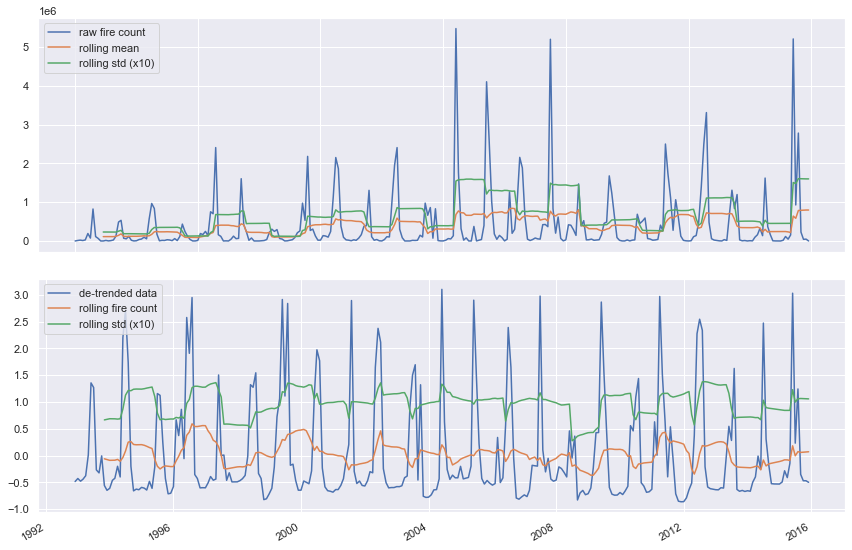

In [66]:
data['fire_size_z_data'] = (data['fire_size'] - data['fire_size'].rolling(window=12).mean()) / data['fire_size'].rolling(window=12).std()
data['fire_size_zp_data'] = data['z_data'] - data['z_data'].shift(12)
data['mean_fire_size'] = data['fire_size'].rolling(window=12).mean()

plot_rolling(data, 'fire_size')

In [81]:
check_stationarity(data, 'fire_size')

 > Is the data stationary ?
Test statistic = -3.318
P-value = 0.014
Critical values :
	1%: -3.4542672521624214 - The data is not stationary with 99% confidence
	5%: -2.87206958769775 - The data is  stationary with 95% confidence
	10%: -2.5723807881747534 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.131
P-value = 0.232
Critical values :
	1%: -3.455365238788105 - The data is not stationary with 99% confidence
	5%: -2.8725510317187024 - The data is not stationary with 95% confidence
	10%: -2.5726375763314966 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -2.792
P-value = 0.059
Critical values :
	1%: -3.454355055831705 - The data is not stationary with 99% confidence
	5%: -2.8721080938842976 - The data is not stationary with 95% confidence
	10%: -2.572401325619835 - The data is  stationary with 90% confidence


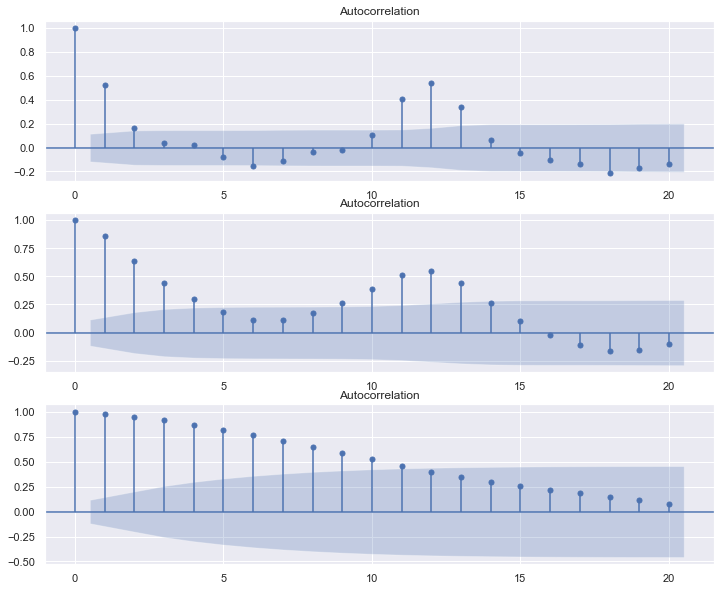

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(3, figsize=(12,10))
ax[0] = plot_acf(data['fire_count'], ax=ax[0], lags=20)
ax[1] = plot_acf(data['exp_fire_count'].dropna(), ax=ax[1], lags=20)
ax[2] = plot_acf(data['mean_fire_count'].dropna(), ax=ax[2], lags=20)

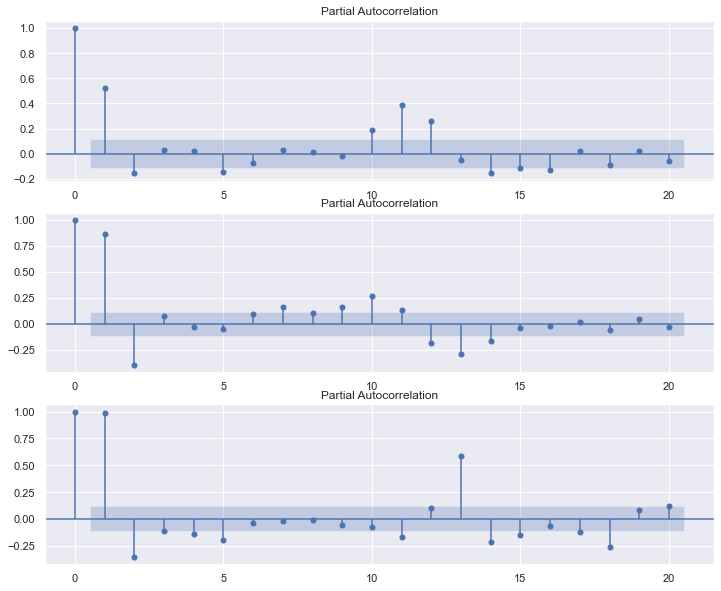

In [83]:
fig, ax = plt.subplots(3, figsize=(12,10))
ax[0] = plot_pacf(data['fire_count'], ax=ax[0], lags=20)
ax[1] = plot_pacf(data['exp_fire_count'].dropna(), ax=ax[1], lags=20)
ax[2] = plot_pacf(data['mean_fire_count'].dropna(), ax=ax[2], lags=20)

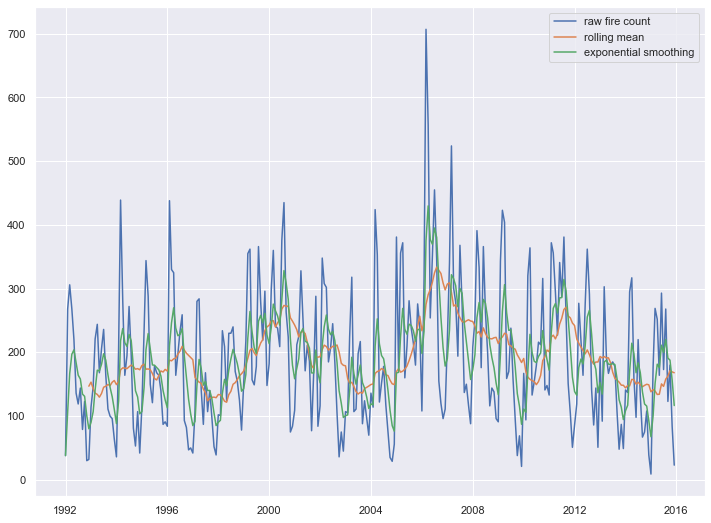

In [84]:
fig, ax = plt.subplots(1,figsize=(12, 9))
ax.plot(data.index, data['fire_count'], label='raw fire count')
ax.plot(data['fire_count'].rolling(window=12).mean(), label="rolling mean")
ax.plot(data['exp_fire_count'], label="exponential smoothing")
ax.legend()

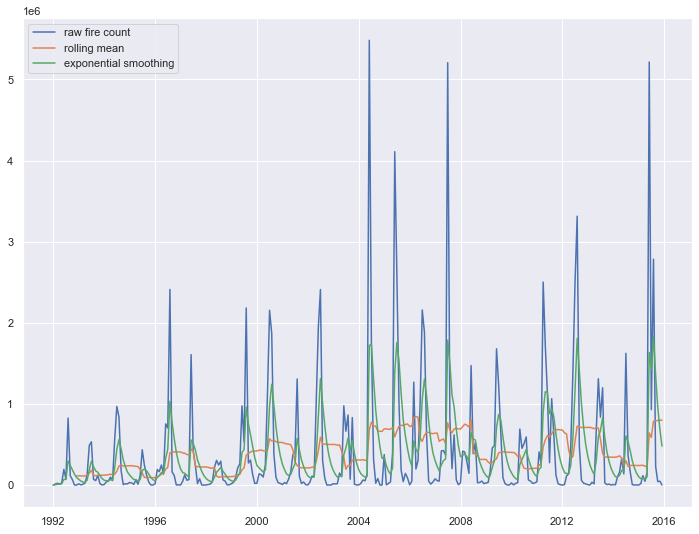

In [85]:
fig, ax = plt.subplots(1,figsize=(12, 9))
ax.plot(data.index, data['fire_size'], label='raw fire count')
ax.plot(data['mean_fire_size'], label="rolling mean")
ax.plot(data['exp_fire_size'], label="exponential smoothing")
ax.legend()

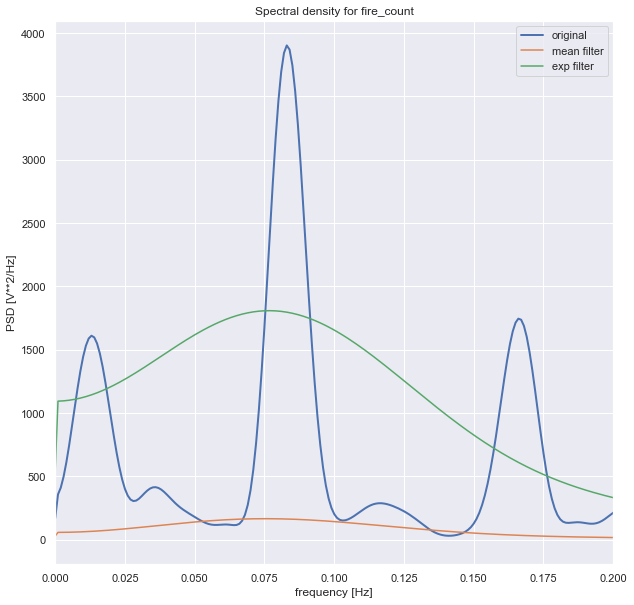

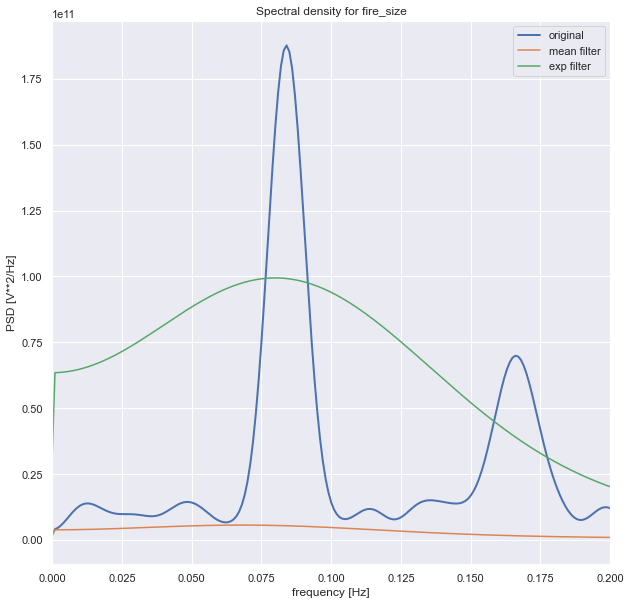

In [87]:
from scipy import signal
window_size = 15
blackman = signal.blackman(M=window_size)

target_columns = ['fire_count', 'fire_size']
#item_columns = target_columns + [f'mean_{item}' for item in target_columns] + [f'gauss_{item}' for item in target_columns]

for column in target_columns:
    f, Pxx_den = signal.welch(data[column], fs=1, scaling='spectrum', nfft = 1000, nperseg=100)
    f_window, Pxx_den_window = signal.welch(data[column].rolling(window=12).mean().dropna(), fs=1, window = blackman, nfft = 1000, scaling='spectrum')
    f_window2, Pxx_den_window2 = signal.welch(data[f'exp_{column}'], fs=1, window = blackman, nfft = 1000, scaling='spectrum')


    Pxx_den = [item.real for item in Pxx_den]
    f =  [item.real for item in f]
    f_window = [item.real for item in f_window]
    Pxx_den_window = [item.real for item in Pxx_den_window]
    f_window2 = [item.real for item in f_window2]
    Pxx_den_window2 = [item.real for item in Pxx_den_window2]
    #f_window_bart = [item.real for item in f_window_bart]
    #Pxx_den_window_bart = [item.real for item in Pxx_den_window_bart]

    plt.plot(f, Pxx_den, linewidth=2, label = 'original')
    plt.plot(f_window, Pxx_den_window, label = 'mean filter')
    plt.plot(f_window2, Pxx_den_window2, label = 'exp filter')

    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.legend(loc='best')
    plt.title(f'Spectral density for {column}')
    plt.xlim((0,0.2))
    plt.show()

In [94]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split

In [139]:
test_size = 0.2
start_idx = data.shape[0]*(1-test_size)//1

X_data = data[weather_columns]
target_columns = ['fire_count', 'mean_fire_count', 'exp_fire_size', 'fire_size', 'mean_fire_size', 'exp_fire_size']
Y_data = data[target_columns]

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data['fire_count'], test_size = test_size, shuffle = False)

In [117]:
model = AutoReg(np.array(y_train, dtype=float), lags=24)
model_fit = model.fit()

/Users/ipavelyev/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


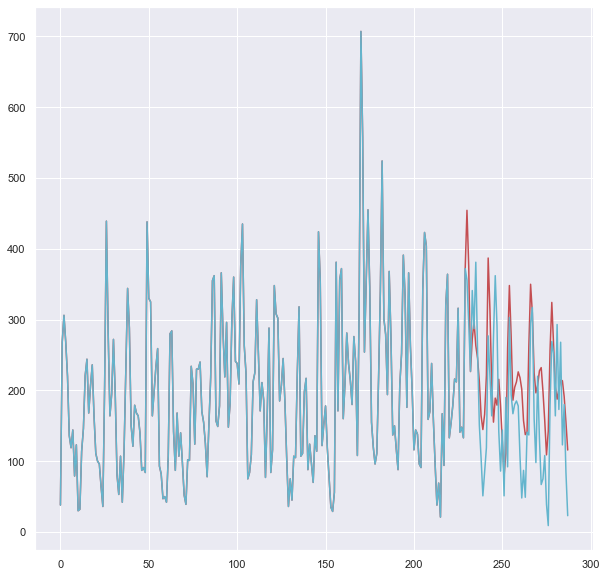

In [118]:
predict = model_fit.predict(start = int(start_idx), end = data.shape[0]-1)
plt.plot(np.concatenate([y_train, predict]), "r", label = "Actual")
plt.plot(Y_data['fire_count'].values, "c", label = "Actual")

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data['fire_size'], test_size = test_size, shuffle = False)
model = AutoReg(np.array(y_train, dtype=float), lags=24)
model_fit = model.fit()

/Users/ipavelyev/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


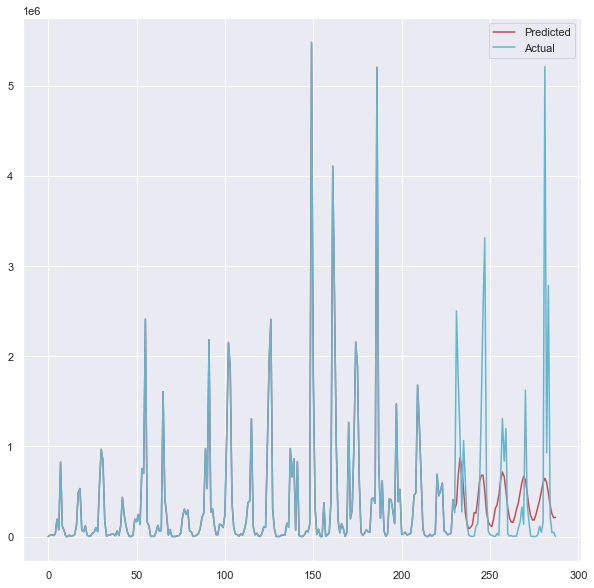

In [112]:
predict = model_fit.predict(start = int(start_idx), end = data.shape[0]-1)
plt.plot(np.concatenate([y_train, predict]), "r", label = "Predicted")
plt.plot(Y_data['fire_size'].values, "c", label = "Actual")
plt.legend()

In [128]:
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro

model = VAR(y_train.iloc[12:,:].astype(float), X_train.iloc[12:,:].astype(float))
model_fit = model.fit()
#model_fit.summary()

/Users/ipavelyev/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Residuals mean: 1.6140387541601598e-11 
Residuals std: 88.66003513983307
ShapiroResult(statistic=0.9554453492164612, pvalue=2.805996018651058e-06)


/Users/ipavelyev/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


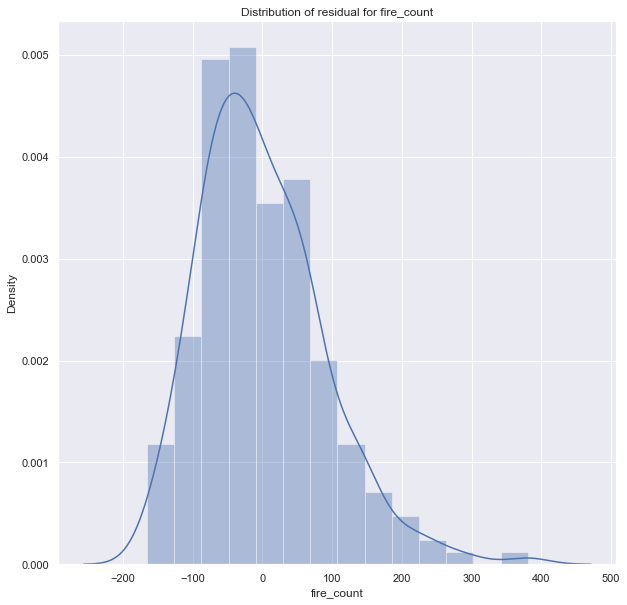

/Users/ipavelyev/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Residuals mean: -1.9616873409856038e-12 
Residuals std: 8.46913001785224
ShapiroResult(statistic=0.9794596433639526, pvalue=0.002965504303574562)


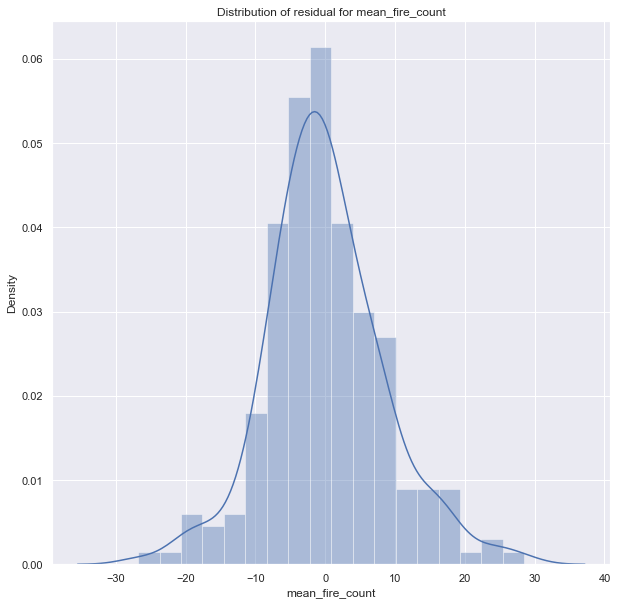

/Users/ipavelyev/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Residuals mean: exp_fire_size   -2.944503e-08
exp_fire_size   -3.036522e-08
dtype: float64 
Residuals std: exp_fire_size    194748.701718
exp_fire_size    194748.701718
dtype: float64
ShapiroResult(statistic=0.6188926696777344, pvalue=7.483575452476099e-30)


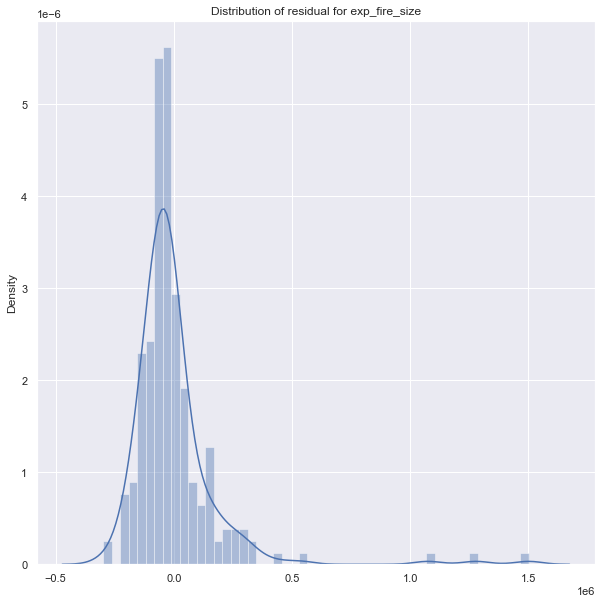

/Users/ipavelyev/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Residuals mean: -1.2919364694488762e-07 
Residuals std: 649162.3390600225
ShapiroResult(statistic=0.6205980777740479, pvalue=1.1671453819637865e-21)


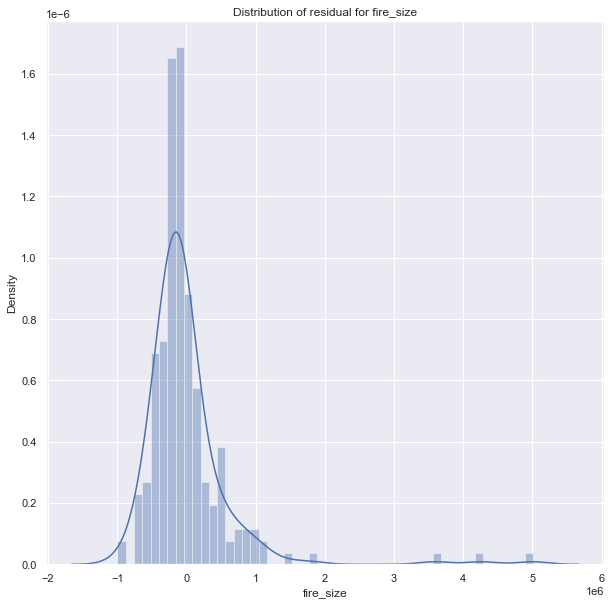

/Users/ipavelyev/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Residuals mean: -1.0314156099604572e-08 
Residuals std: 59785.71663226013
ShapiroResult(statistic=0.7672194838523865, pvalue=3.127011383713402e-17)


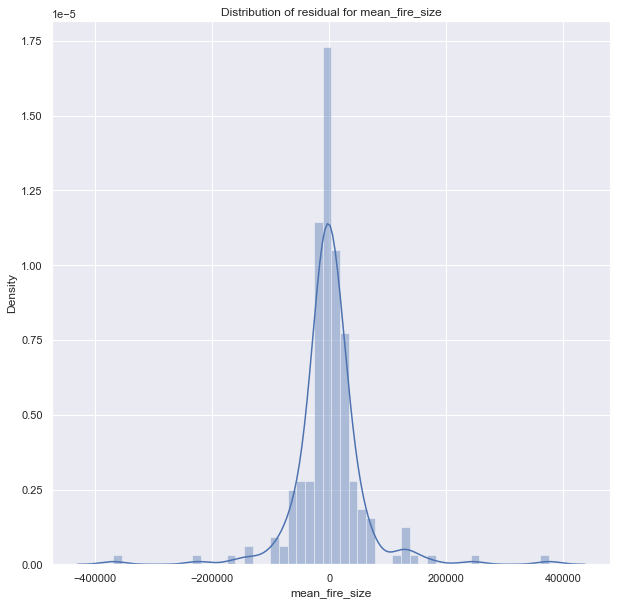

/Users/ipavelyev/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Residuals mean: exp_fire_size   -2.944503e-08
exp_fire_size   -3.036522e-08
dtype: float64 
Residuals std: exp_fire_size    194748.701718
exp_fire_size    194748.701718
dtype: float64
ShapiroResult(statistic=0.6188926696777344, pvalue=7.483575452476099e-30)


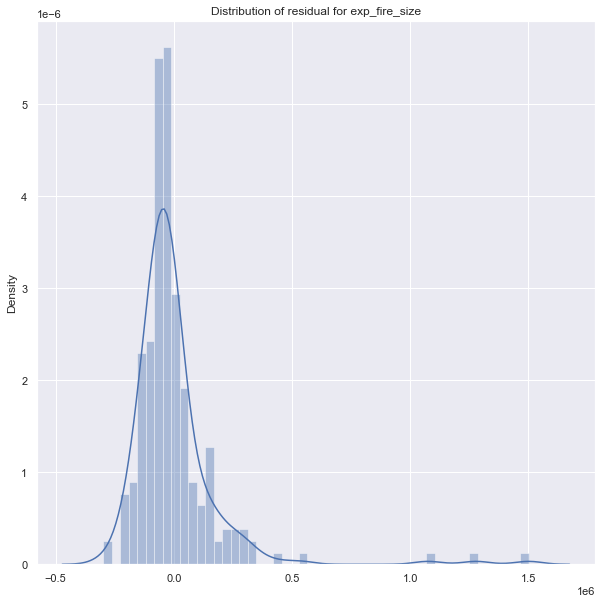

In [129]:
for item in model_fit.resid:
    residuals = model_fit.resid[item]
    sns.distplot(residuals, kde=True, norm_hist=True)
    plt.title(f'Distribution of residual for {item}')
    print(f'Residuals mean: {residuals.mean()} \nResiduals std: {residuals.std()}\n{shapiro(residuals)}')
    plt.show()

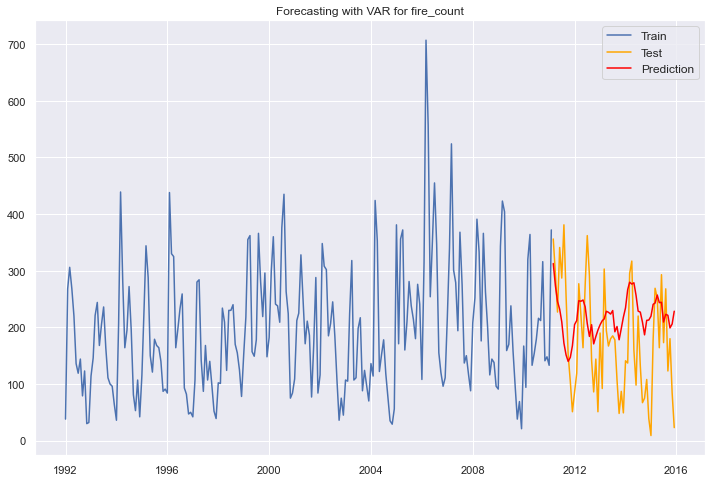

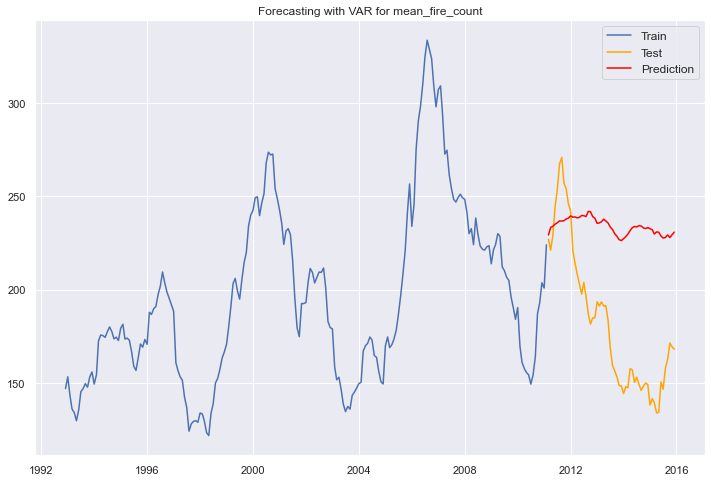

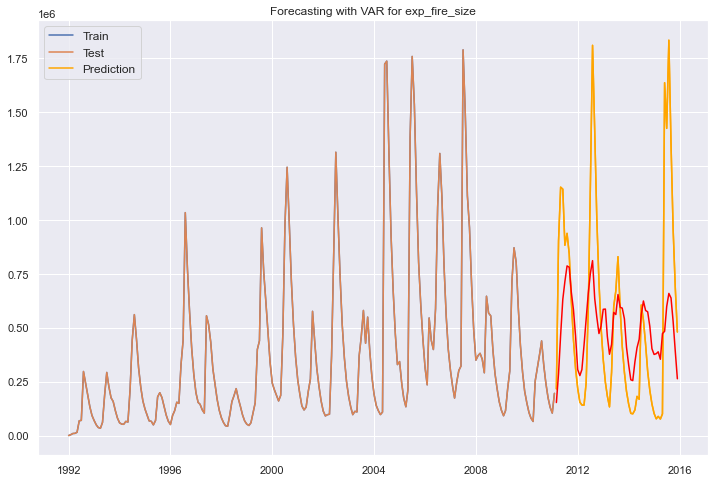

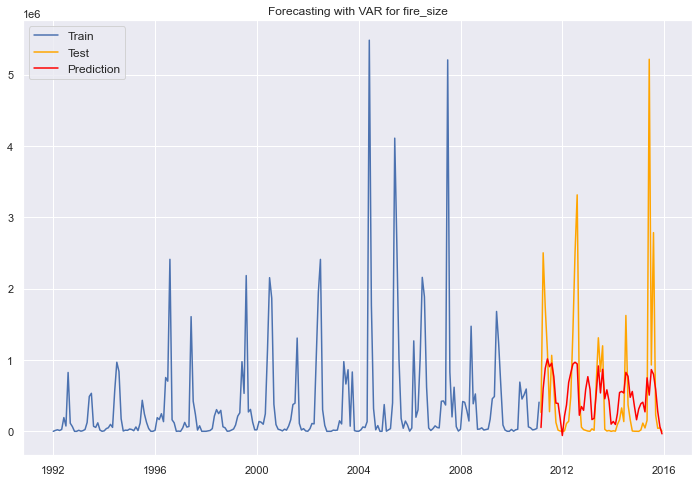

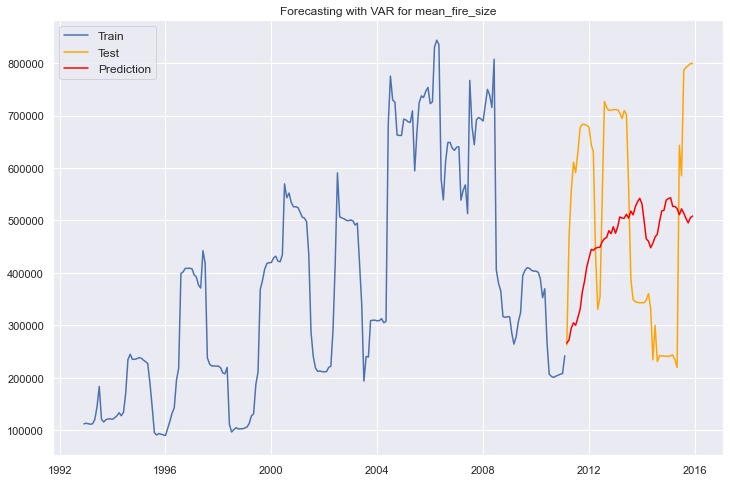

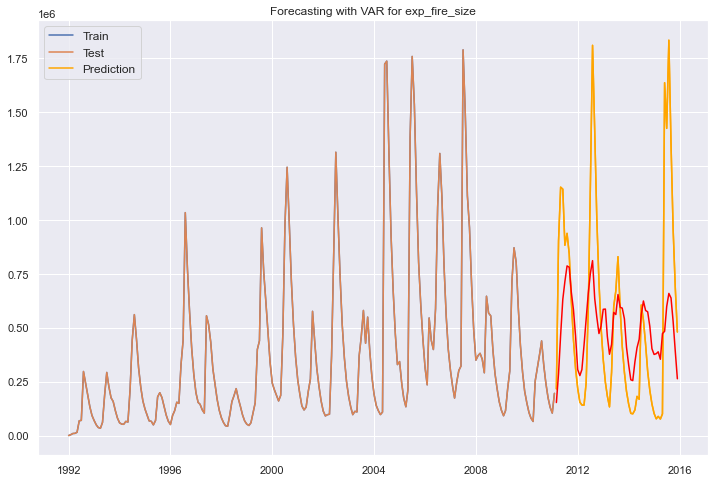

In [140]:
i = 0

for item in target_columns:
    predict = model_fit.forecast(model_fit.endog, 58, exog_future=X_test)[:,i]
    i+=1
    
    plt.figure(figsize=(12, 8))
    plt.plot(list(X_train.index.values), list(y_train[item].values))
    plt.plot(list(X_test.index.values), list(y_test[item].values), color = 'orange')
    plt.plot(list(X_test.index.values), predict, color="red")
    plt.legend(["Train", "Test", "Prediction"], prop={"size": 12})
    plt.title(f'Forecasting with VAR for {item}')

In [141]:
residuals = model_fit.resid
print(f'Residuals mean: {residuals.mean()} \n\nResiduals std: {residuals.std()}\n')

Residuals mean: fire_count         1.614039e-11
mean_fire_count   -1.961687e-12
exp_fire_size     -2.944503e-08
fire_size         -1.291936e-07
mean_fire_size    -1.031416e-08
exp_fire_size     -3.036522e-08
dtype: float64 

Residuals std: fire_count             88.660035
mean_fire_count         8.469130
exp_fire_size      194748.701718
fire_size          649162.339060
mean_fire_size      59785.716632
exp_fire_size      194748.701718
dtype: float64

